In [60]:
import wandb
from train_subject_models import FUNCTION_NAMES
from datetime import datetime

api = wandb.Api()
runs = api.runs(
    path='patrickaaleask/bounding-mi',
    filters= {
        'config.functions': FUNCTION_NAMES,
        'State': 'finished',
        'created_at': {
            '$gt': "2023-06-26T00:00:00",
            '$lt': "2023-06-27T00:00:00",
        },
    },
)
print(f'Found {len(list(runs))} runs')

Found 60 runs


In [99]:
import pandas as pd
from scipy import stats

df = pd.DataFrame([(run.config['weight_decay'], run.summary['validation_loss']) for run in runs], columns=['Weight Decay', 'Validation Loss'])


F-value: 7819.33
p-value: 6.647503941303006e-76


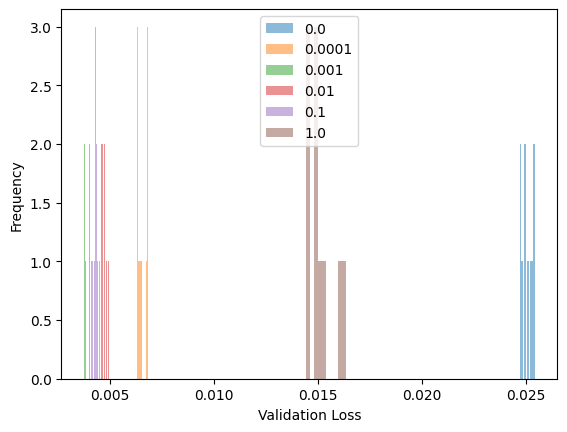

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis object
fig, ax = plt.subplots()

# Group the dataframe by 'Class'
grouped = df.groupby('Weight Decay')

# Create a list of data for each class
data = [group['Validation Loss'].tolist() for name, group in grouped]

# Plot the boxplot
ax.boxplot(data, labels=grouped.groups.keys())

# Set x-axis and y-axis labels
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Validation Loss')

# Show the plot
plt.show()

In [100]:
weight_decays = sorted(df['Weight Decay'].unique())

f_value, p_value = stats.f_oneway(*[df['Validation Loss'][df['Weight Decay'] == weight_decay] for weight_decay in weight_decays])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value}')

F-value: 7819.33
p-value: 6.647503941303006e-76
